### Aryl Halide Clustering
#### 1. Process dataset and remove highly correlated features (R2 > 0.95)
#### 2. Compare PCA and UMAP for dimensionality reduction and clustering
#### 3. Make optimal clusters and visualize molecules closest to cluster centers

In [1]:
# package imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw

# scikit learn!
import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata
from scipy.spatial.distance import cdist

# umap for dimensionality reduction
import umap

# nice plotting
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns; sns.set()

/home/intel00000/miniconda3/envs/arylbr_linux/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# cleaned aryl X dataset
# We kept parameters for the low energy conformer (removing those for min/max and Bolztmann average, which are highly correlated)
arylx = pd.read_csv('arylx.csv')
arylx.head()

,id,smiles,HOMO_low_E,LUMO_low_E,η_low_E,μ_low_E,ω_low_E,polar_aniso(Debye)_low_E,polar_iso(Debye)_low_E,dipole(Debye)_low_E,...,%Vbur_Br_2.5Å_low_E,%Vbur_C_3.0Å_low_E,%Vbur_Br_3.0Å_low_E,%Vbur_C_3.5Å_low_E,%Vbur_Br_3.5Å_low_E,%Vbur_C_4.0Å_low_E,%Vbur_Br_4.0Å_low_E,Sterimol_B1_C_Br(Å)_morfeus_low_E,Sterimol_B5_C_Br(Å)_morfeus_low_E,Sterimol_L_C_Br(Å)_morfeus_low_E
0,arbr141,Cc1[nH]nc(C(F)(F)F)c1Br,-0.30770,0.01581,0.32351,-0.145945,0.03292,43.1852,89.2019,5.5518,...,34.132048,78.811271,33.014563,68.080856,31.508572,56.128189,29.409255,2.277507,4.841637,4.126049
1,arbr142,Cc1[nH]nc(-c2ccccc2)c1Br,-0.27821,0.00248,0.28069,-0.137865,0.03386,102.7150,147.4390,2.8706,...,36.231931,77.875447,34.498845,67.397153,32.274390,55.776721,29.634644,2.077762,7.508006,4.136710
2,arbr143,Cc1cc(C(C)(C)C)cc(C)c1Br,-0.28384,0.01480,0.29864,-0.134520,0.03030,86.5084,162.0250,1.8175,...,36.599818,79.910980,35.651631,70.185543,33.763511,58.853811,30.847713,2.968765,4.479852,4.170312
3,arbr145,Cc1cccc(Cl)c1Br,-0.30209,-0.00082,0.30127,-0.151455,0.03807,69.3040,110.6700,2.6224,...,36.397968,79.426773,35.005401,69.397596,32.937127,57.807554,30.127708,1.868018,4.498470,4.153900
4,arbr146,Cc1cccc(F)c1Br,-0.30220,0.00107,0.30327,-0.150565,0.03738,62.0065,98.2669,2.6395,...,34.662716,78.545888,33.005252,67.583512,30.757315,55.012104,27.829201,1.850000,4.454212,4.152511


In [3]:
# the molecular descriptors
X = arylx.select_dtypes(include=['number'])

# Feature scaling through standardization (or Z-score normalization) is an important preprocessing step 
# for many machine learning algorithms. Standardization involves rescaling the features such that they 
# have the properties of a standard normal distribution with a mean of zero and a standard deviation of one. 

X_scaled=pd.DataFrame(scale(X),index=X.index, columns=X.columns)

# drop zero-variance features
zero_std_cols = X_scaled.columns[X_scaled.std() == 0]
X_scaled=X_scaled[X_scaled.columns.difference(zero_std_cols)]
print (f"Dropping {len(zero_std_cols)} features {zero_std_cols}")

# drop highly correlated features
corr = X_scaled.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X_scaled = X_scaled.drop(to_drop, axis=1)
print (f"Dropping {len(to_drop)} features {to_drop}")

Dropping 0 features Index([], dtype='object')
Dropping 10 features ['ω_low_E', 'SASA_surface_area(Å²)_low_E', 'SASA_volume(Å³)_low_E', 'pyramidalization_Gavrish_C(°)_low_E', '%Vbur_Br_2.5Å_low_E', '%Vbur_Br_3.0Å_low_E', '%Vbur_C_3.5Å_low_E', '%Vbur_Br_3.5Å_low_E', '%Vbur_C_4.0Å_low_E', '%Vbur_Br_4.0Å_low_E']


In [4]:
X_scaled.head()

,HOMO_low_E,LUMO_low_E,η_low_E,μ_low_E,polar_aniso(Debye)_low_E,polar_iso(Debye)_low_E,dipole(Debye)_low_E,volume(Bohr_radius³/mol)_low_E,SASA_sphericity_low_E,NBO_charge_Br_low_E,...,pyramidalization_Agranat-Radhakrishnan_C_low_E,NBO_LP_energy_Br_low_E,NBO_LP_occupancy_Br_low_E,%Vbur_C_2.0Å_low_E,%Vbur_Br_2.0Å_low_E,%Vbur_C_2.5Å_low_E,%Vbur_C_3.0Å_low_E,Sterimol_B1_C_Br(Å)_morfeus_low_E,Sterimol_B5_C_Br(Å)_morfeus_low_E,Sterimol_L_C_Br(Å)_morfeus_low_E
0,-0.662377,1.665360,2.231269,0.754691,-1.580527,-1.507738,1.917174,-0.849583,1.134697,1.356760,...,-0.454564,-0.504804,1.228426,-0.139160,0.656509,0.887520,1.480351,1.195502,-0.633773,-0.255286
1,0.926729,1.097343,0.371520,1.209931,0.167396,-0.007780,0.020707,0.195476,0.099138,0.096874,...,4.280327,0.431995,1.982498,-0.209054,2.074293,0.358087,1.058218,0.367962,1.087865,-0.207194
2,0.623350,1.622322,1.151120,1.398394,-0.308464,0.367897,-0.724172,1.000581,0.065236,-1.836176,...,-0.455547,1.391285,0.416792,0.210312,1.640756,1.057751,1.976409,4.059369,-0.867373,-0.055611
3,-0.360075,0.956723,1.265346,0.444249,-0.813622,-0.954804,-0.154850,-0.935549,1.543756,0.143812,...,-0.455256,0.428621,-0.656753,0.175364,1.879787,0.973416,1.757992,-0.501005,-0.855352,-0.129647
4,-0.366002,1.037260,1.352209,0.494393,-1.027893,-1.274259,-0.142755,-0.932373,1.707934,0.073014,...,-0.455552,0.387010,-0.037954,0.357090,1.036147,0.817241,1.360642,-0.575652,-0.883928,-0.135913


#### At this point we have 22 descriptors remaining

In [5]:
# define the dimensionalities of the reduced representation to study
# We will compare the performance of clustering based on reduced dimensionality representations of size 3 and 2 dimensions
# Because tSNE cannot convert high dimension data, we only use size 3 and 3 dimensions
dims = [3, 2]

# dictionary to store data at different levels of dimensionality reduction
dfs={}

# UMAP
np.random.seed(0)
n_neighbors = int(np.sqrt(X_scaled.shape[1]))
for dim in dims:
    key = f"umap{dim}"
    dfs[key] = pd.DataFrame(umap.UMAP(n_components=dim, n_neighbors=n_neighbors, random_state=np.random.RandomState(0)).fit_transform(X_scaled),
    index=X_scaled.index)

# PCA
for dim in dims:
    pc = pd.DataFrame(PCA(n_components=dim).fit_transform(X_scaled), index=X_scaled.index)
    key = f"pc{dim}"
    dfs[key] = pc.iloc[:, :dim]

# tSNE
for dim in dims:
    tsne = pd.DataFrame(TSNE(n_components=dim, max_iter=1000, random_state=0).fit_transform(X_scaled), index=X_scaled.index)
    key = f"tsne{dim}"
    dfs[key] = tsne.iloc[:, :dim]

# The user warnings are not concerning - relate to running calculations on 1 vs. several processors

/home/intel00000/miniconda3/envs/arylbr_linux/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/intel00000/miniconda3/envs/arylbr_linux/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Text(0.5, 1.0, 'tSNE projection')

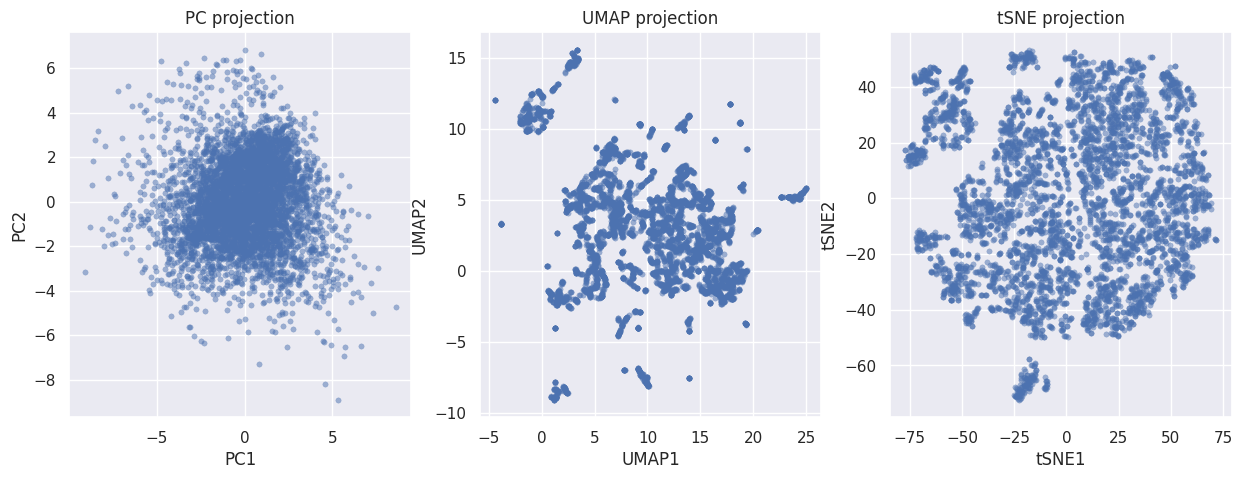

In [6]:
# Visualize the embeddings
f, ax = plt.subplots(1, 3, figsize=(15, 5))  # , dpi=200)

dfs["pc2"].columns = ["PC1", "PC2"]
dfs["umap2"].rename(columns={0: "UMAP1", 1: "UMAP2"}, inplace=True)
dfs["tsne2"].columns = ["tSNE1", "tSNE2"]

sns.scatterplot(
    x="PC1",
    y="PC2",
    data=dfs["pc2"],
    s=15,
    alpha=0.5,
    linewidth=0.25,
    edgecolor="face",
    ax=ax[0],
).set_title("PC projection")
sns.scatterplot(
    x="UMAP1",
    y="UMAP2",
    data=dfs["umap2"],
    s=15,
    alpha=0.5,
    linewidth=0.25,
    edgecolor="face",
    ax=ax[1],
).set_title("UMAP projection")
sns.scatterplot(
    x="tSNE1",
    y="tSNE2",
    data=dfs["tsne2"],
    s=15,
    alpha=0.5,
    linewidth=0.25,
    edgecolor="face",
    ax=ax[2],
).set_title("tSNE projection")

In [7]:
# run another UMAP, compare the result with the first run
n_neighbors = int(np.sqrt(X_scaled.shape[1]))
print(n_neighbors)
for dim in dims:
    key = f"umap_rerun_{dim}"
    dfs[key] = pd.DataFrame(umap.UMAP(n_components=dim, n_neighbors=n_neighbors, random_state=0).fit_transform(X_scaled),
    index=X_scaled.index)

4


/home/intel00000/miniconda3/envs/arylbr_linux/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/intel00000/miniconda3/envs/arylbr_linux/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [8]:
dfs

{'umap3':               0         1         2
 0      6.189672 -1.485897  3.988679
 1      6.040309 -1.167155  0.580791
 2     12.658140  9.050476  8.995178
 3      9.099941  1.452189 -1.704013
 4      9.238244  1.152078 -1.242163
 ...         ...       ...       ...
 5041  11.363766  7.066610  6.484920
 5042  11.308736  7.034693  6.366005
 5043  11.298976  4.035007  5.678765
 5044   9.210274  4.096093  5.891119
 5045  12.533792  5.991781  6.122096
 
 [5046 rows x 3 columns],
 'umap2':           UMAP1      UMAP2
 0     13.448611  10.372487
 1      9.119054  -4.026840
 2      5.313938  -1.880707
 3      5.697520  -0.187125
 4      5.341497   0.803906
 ...         ...        ...
 5041  11.978932   5.396379
 5042  12.039770   5.201891
 5043  12.164690   1.794998
 5044   9.766582   1.620858
 5045  12.642423   3.252968
 
 [5046 rows x 2 columns],
 'pc3':              0         1         2
 0    -0.695339  2.996261  3.271302
 1     2.880551  1.330293  2.794933
 2     2.824843  1.420231  1.55

Text(0.5, 1.0, 'tSNE projection')

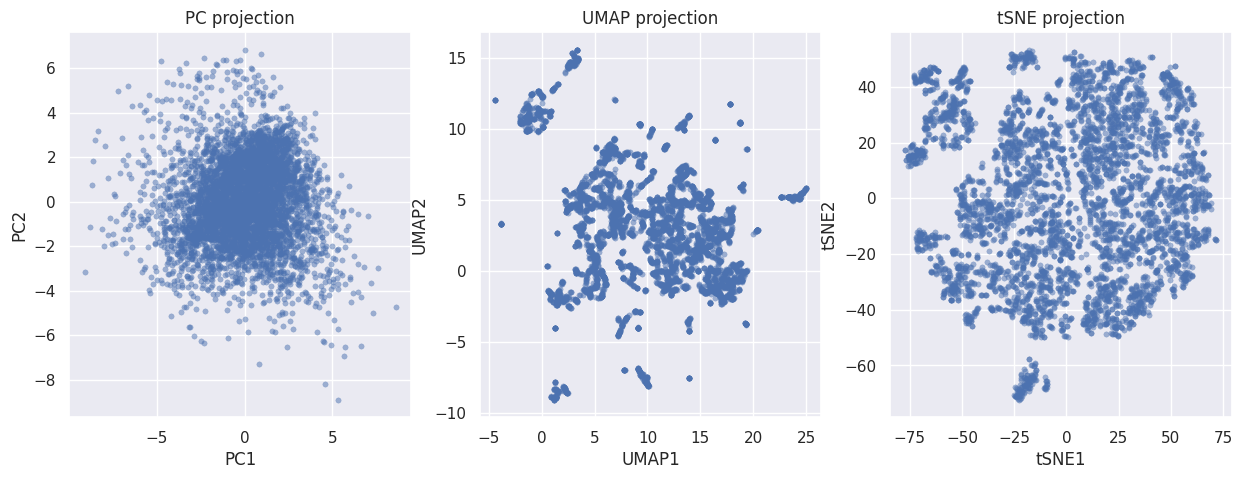

In [9]:
# Visualize the embeddings
f, ax = plt.subplots(1, 3, figsize=(15, 5)) #, dpi=200)

dfs['pc2'].columns = ['PC1', 'PC2']
dfs['umap2'].rename(columns={0:'UMAP1', 1:'UMAP2'}, inplace=True)
dfs['tsne2'].columns = ['tSNE1', 'tSNE2']

sns.scatterplot(x='PC1', y='PC2', data=dfs['pc2'], s=15, alpha=0.5, linewidth=0.25, edgecolor='face', ax=ax[0]).set_title("PC projection")
sns.scatterplot(x='UMAP1', y='UMAP2', data=dfs['umap2'], s=15, alpha=0.5, linewidth=0.25, edgecolor='face', ax=ax[1]).set_title("UMAP projection")
sns.scatterplot(x='tSNE1', y='tSNE2', data=dfs['tsne2'], s=15, alpha=0.5, linewidth=0.25, edgecolor='face', ax=ax[2]).set_title("tSNE projection")

<Axes: xlabel='number of clusters', ylabel='silhouette score'>

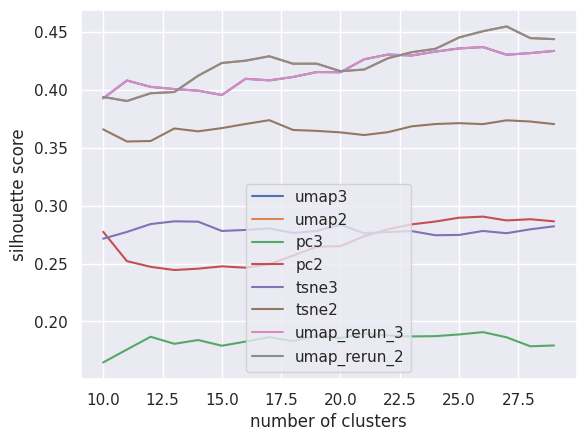

In [10]:
# Testing the quality of clustering approaches
# Here we compare the effect of different dimensionality representations and the number of clusters
# The sillhouette score quantifies the intra-cluster distance vs. inter-cluster distance.

# Define the numbeor of clusters to study
N_CLS_list = list(range(10, 30))

def silhouette_scores_hierarchical(data, n_cls_list):
    """helper function to compute a silhouette score for hierarchical clustering using Ward linkage"""
    z = linkage(data, method='ward')
    result = pd.Series(index=n_cls_list, dtype=float)
    for n_cls in n_cls_list:
        cls = fcluster(z, n_cls, criterion='maxclust')
        result.loc[n_cls] = silhouette_score(data, cls)
    return result

# populate silhouette scores for all number of clusters and all dimensionality reductions that are pre-calculated
silh_scores = pd.DataFrame(index=N_CLS_list)

for key, value in dfs.items():
    silh_scores[key] = silhouette_scores_hierarchical(value, N_CLS_list)

# plot the silhouette scores
silh_scores.plot(xlabel='number of clusters',ylabel='silhouette score')

In [11]:
# Testing the quality of clustering approaches using different scoring methods
# DBCV ref: Moulavi, Davoud, et al. "Density-based clustering validation." Proceedings of the 2014 SIAM International Conference on Data Mining. Society for Industrial and Applied Mathematics, 2014.
# To install dbcv: python -m pip install "git+https://github.com/FelSiq/DBCV"
import dbcv

# Define the numbeor of clusters to study
N_CLS_list = list(range(10, 30))

def dbcv_scores_hierarchical(data, n_cls_list):
    """helper function to compute a dbcv score for hierarchical clustering using Ward linkage"""
    z = linkage(data, method='ward')
    result = pd.Series(index=n_cls_list, dtype=float)
    for n_cls in n_cls_list:
        cls = fcluster(z, n_cls, criterion='maxclust')
        result.loc[n_cls] = dbcv.dbcv(data, cls)
    return result

# populate dbcv scores for all number of clusters and all dimensionality reductions that are pre-calculated
dbcv_scores = pd.DataFrame(index=N_CLS_list)

for key, value in dfs.items():
    dbcv_scores[key] = dbcv_scores_hierarchical(value, N_CLS_list)

# plot the dbcv scores
dbcv_scores.plot(xlabel='number of clusters',ylabel='DBCV score')

ModuleNotFoundError: No module named 'dbcv'

In [12]:
# From the plots above:
# UMAP leads to better quality clusters compared to PCA (higher sillhouette scores overall)
# For the UMAP results, using 5, 10 or 20 dimensions gives similar performance
# for lower cluster numbers, (10-12), 2 dimensions works best

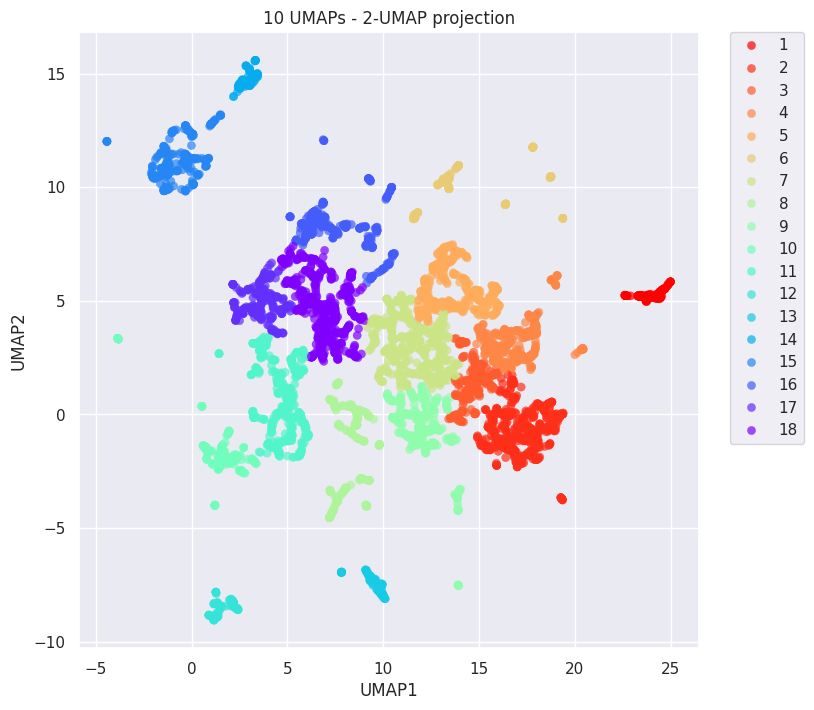

In [13]:
# final number of clusters to produce (in the case of UMAP)
NCLS = 18
features='umap2'

# linkage and clustering for selected featurization
z = linkage(dfs[features], method="ward")
cls = fcluster(z, NCLS, criterion='maxclust')

# plot clustering
plt.figure(figsize=(8, 8))
sns.scatterplot(x="UMAP1", y="UMAP2", data=dfs['umap2'], s=35, alpha=0.7, linewidth=0.25, edgecolor='face',
palette='rainbow_r', legend='full', hue=cls).set_title("10 UMAPs - 2-UMAP projection")
_=plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

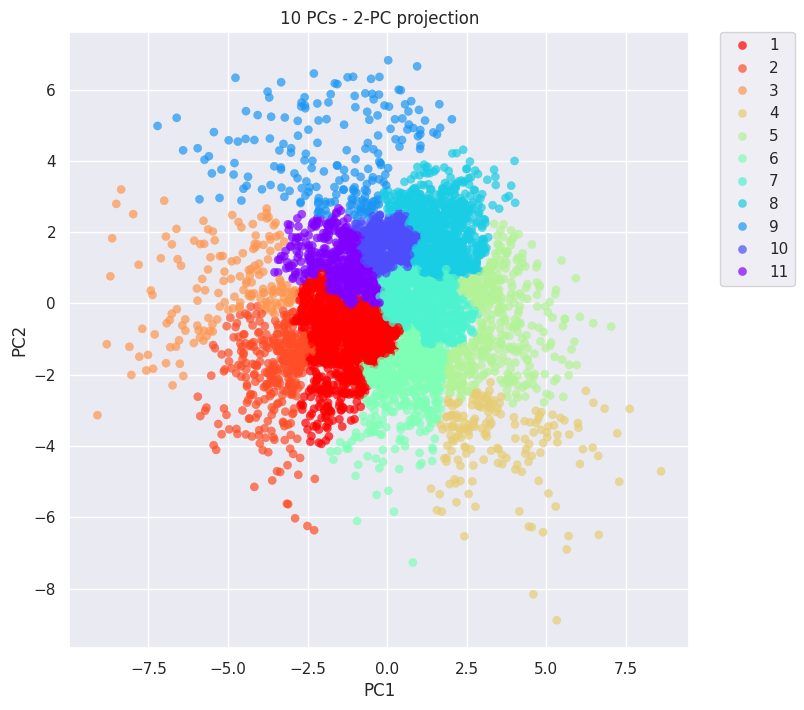

In [14]:
# final number of clusters to produce (in the case of PCA)
NCLS = 11
features='pc2'

# linkage and clustering for selected featurization
z = linkage(dfs[features], method="ward")
cls = fcluster(z, NCLS, criterion='maxclust')

# plot clustering
plt.figure(figsize=(8, 8))
sns.scatterplot(x="PC1", y="PC2", data=dfs['pc2'], s=35, alpha=0.7, linewidth=0.25, edgecolor='face',
palette='rainbow_r', legend='full', hue=cls).set_title("10 PCs - 2-PC projection")
_=plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

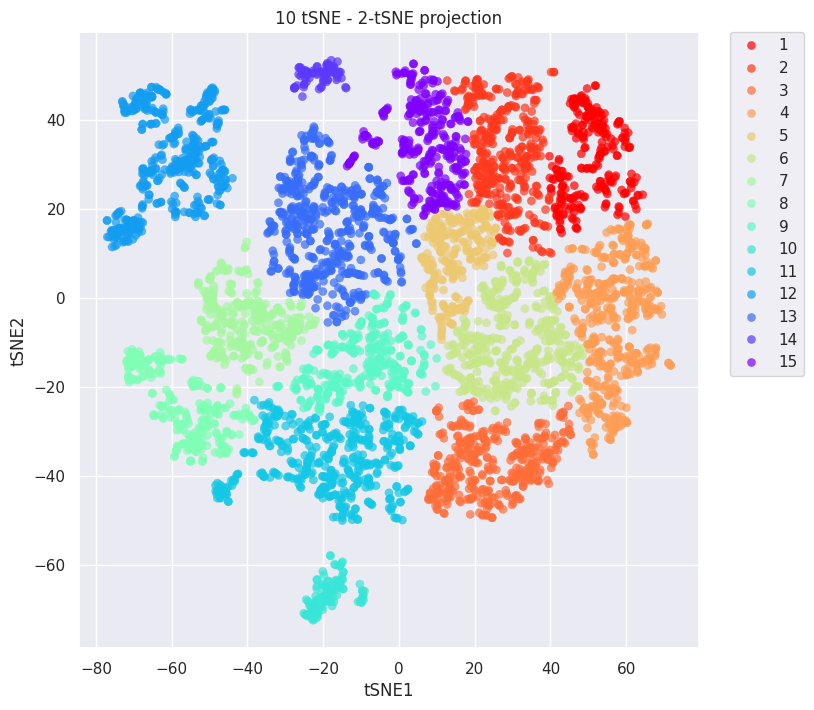

In [15]:
# final number of clusters to produce (in the case of tSNE)
NCLS = 15
features='tsne2'


# linkage and clustering for selected featurization
z = linkage(dfs[features], method="ward")
cls = fcluster(z, NCLS, criterion='maxclust')

# plot clustering
plt.figure(figsize=(8, 8))
sns.scatterplot(x="tSNE1", y="tSNE2", data=dfs[features], s=35, alpha=0.7, linewidth=0.25, edgecolor='face',
palette='rainbow_r', legend='full', hue=cls).set_title("10 tSNE - 2-tSNE projection")
_=plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Cluster 1, n molecules: 255


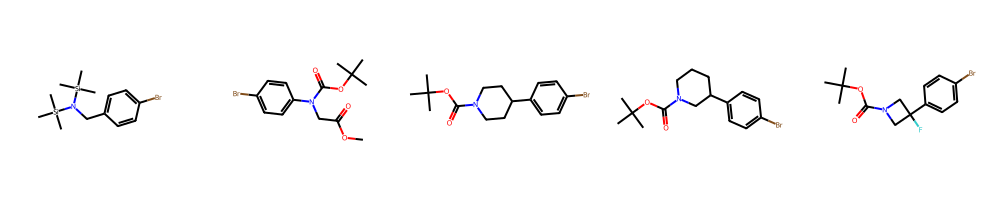

Cluster 2, n molecules: 382


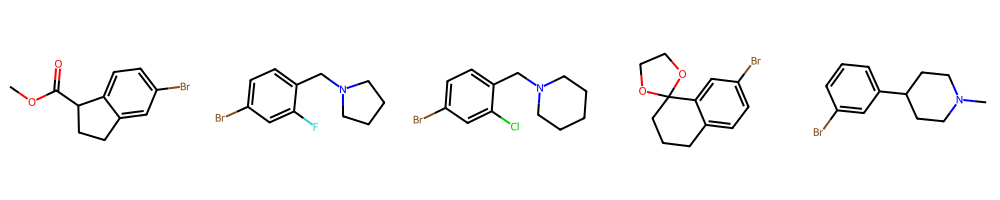

Cluster 3, n molecules: 404


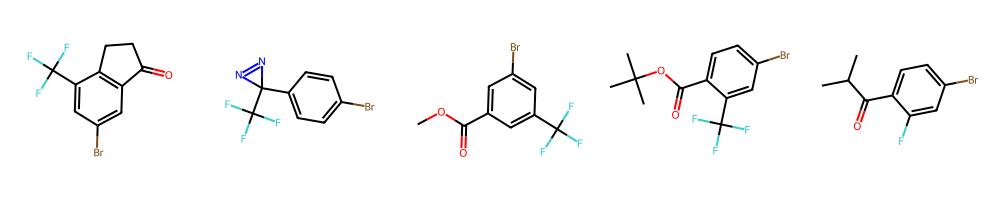

Cluster 4, n molecules: 480


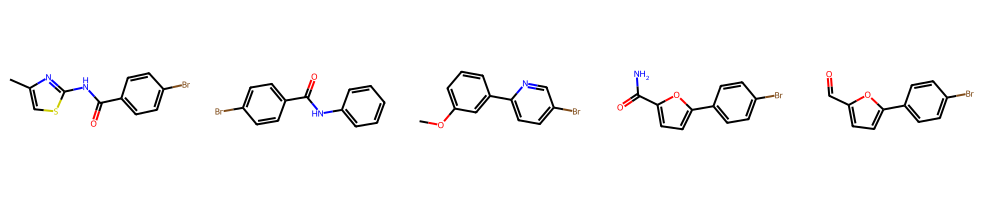

Cluster 5, n molecules: 241


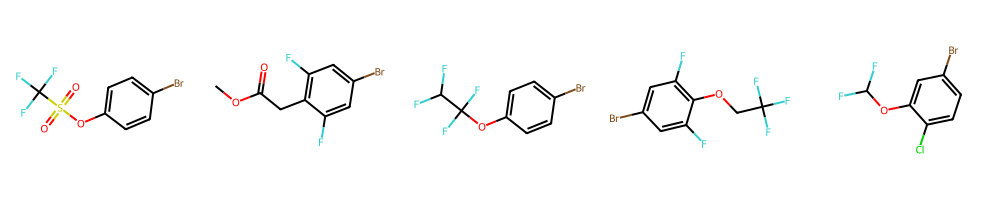

Cluster 6, n molecules: 434


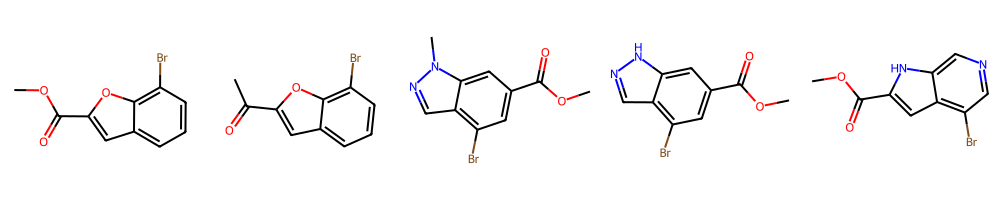

Cluster 7, n molecules: 310


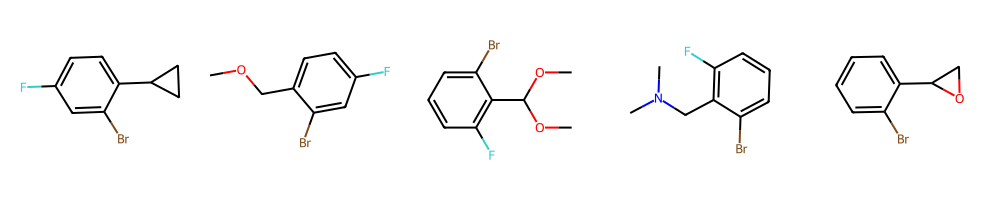

Cluster 8, n molecules: 268


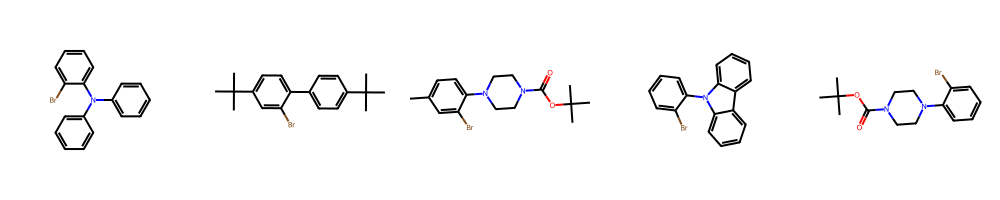

Cluster 9, n molecules: 316


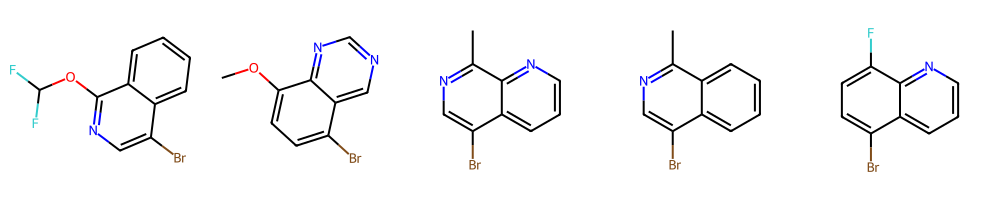

Cluster 10, n molecules: 107


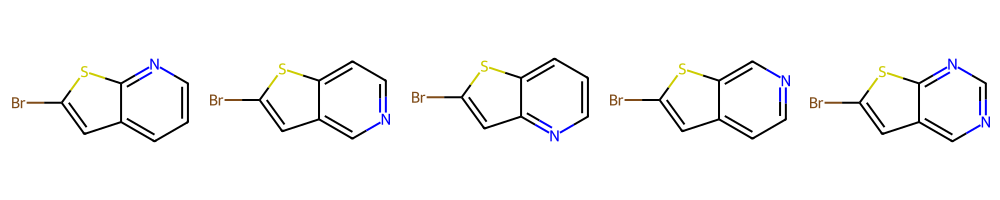

Cluster 11, n molecules: 478


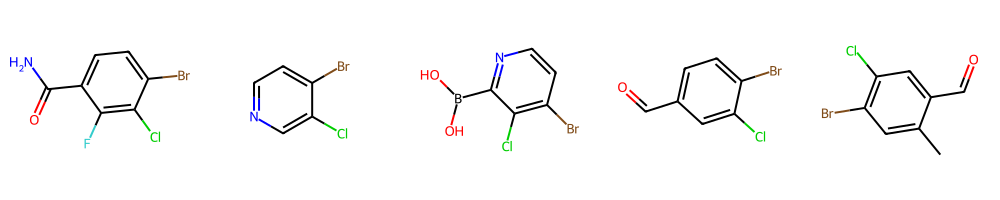

Cluster 12, n molecules: 445


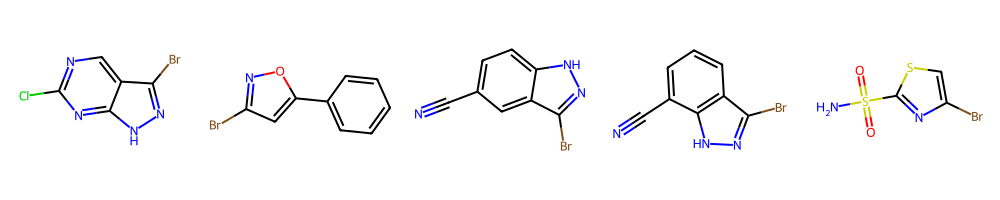

Cluster 13, n molecules: 535


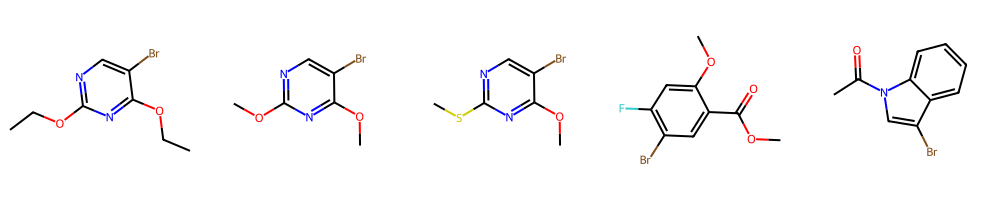

Cluster 14, n molecules: 76


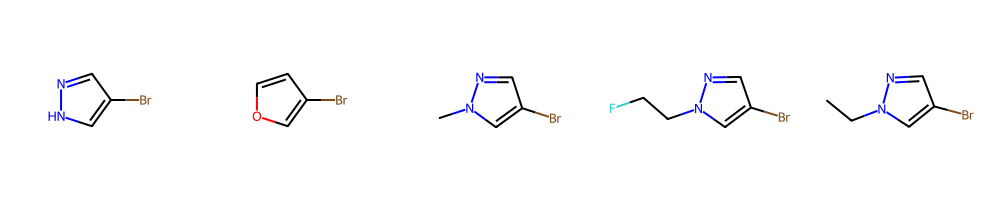

Cluster 15, n molecules: 315


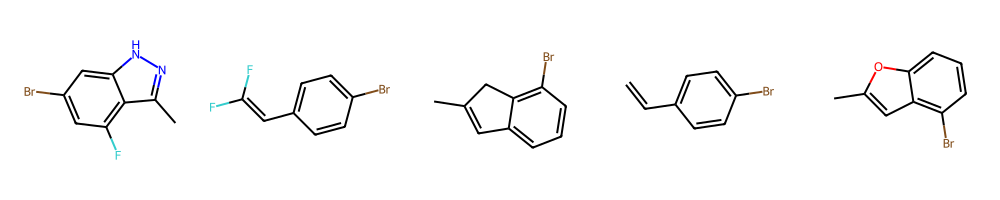

In [16]:
# build rdkit molecules for all candidates
mols = pd.Series([Chem.MolFromSmiles(smi) for smi in arylx.smiles]).to_frame('mol')

# How many central molecules to display?
n_per_cluster = 5

# store central candidates for
cands=[]
for group, data in mols.groupby(cls):
   
    # get descriptor data for this cluster
    print (f"Cluster {group}, n molecules: {len(data)}")
   
    desc_data=dfs[features].loc[data.index]
    
    # compute distances of these molecules to their center
    dists=pd.Series(cdist([desc_data.mean()], desc_data)[0],
    index=desc_data.index)
    
    # select top n central molecules
    selected=dists.sort_values().head(n_per_cluster).index
    smi=mols.loc[selected]['mol'].map(Chem.MolToSmiles)
    smi=smi.reset_index(drop=True).to_frame(f"Cluster{group}")
    cands.append(smi)
    
    ms = data['mol'].loc[selected]
    display(Draw.MolsToGridImage(ms, molsPerRow=n_per_cluster))
    img = Draw.MolsToGridImage(ms, molsPerRow=n_per_cluster)

    png = img.data
    with open('./cluster_'+str(group)+'.png','wb+') as outf:
        outf.write(png)
cands = pd.concat(cands, axis=1)



In [17]:

# make a handful of umaps with various random seeds
umaps = []
for i in range(50):
    umaps.append(pd.DataFrame(umap.UMAP(n_components=10, n_neighbors=n_neighbors).fit_transform(X_scaled),
                              index=X_scaled.index))

        

Text(0, 0.5, 'Frequency')

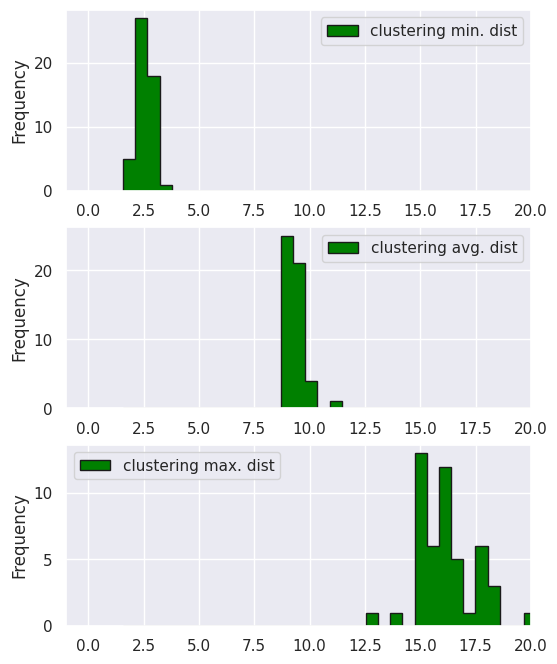

In [18]:
# add the original umap that was used for clustering
umaps = [dfs['umap2']] + umaps

from scipy.spatial.distance import pdist, squareform

def sample_dist(data):
    dists = pdist(data)
    return [ min(dists), np.mean(dists), max(dists)]

def kenStone(X, k, metric='euclidean'):

    # safety checks
    assert isinstance(k, int)
    assert k >= 2
    assert k <= X.shape[0]
    
    # distance matrix
    d = squareform(pdist(X, metric))
    
    # seed pick the pair that's furthest apart
    selected = list(np.unravel_index(np.argmax(d), d.shape))

    while len(selected) < k:
        # add sample whose minimum distance to the selected samples is largest

        selected.append(np.argmax(d[selected,].min(axis=0)))
    
    return selected

# selection of dataset to use
dat = umaps[7]
NCLS=15

ret_cls = []

for dat in umaps:
    # clustering
    z = linkage(dat, method="ward")
    cls = fcluster(z, NCLS, criterion='maxclust')

    selected = []
    for group, d in dat.groupby(cls):
        # compute distances of these molecules to their center
        dists=pd.Series(cdist([d.mean()], d)[0], index=d.index)

        # select top n central molecules
        selected.append(dists.sort_values().index[0])
        
    dcls = sample_dist(dat.loc[selected])
    ret_cls.append(dcls)

ret_cls = pd.DataFrame(ret_cls, columns=[ 'clustering min. dist', 'clustering avg. dist', 'clustering max. dist'])

ret_ks = []
for dat in umaps:
    ks = kenStone(dat, NCLS)
    dks = sample_dist(dat.iloc[ks])
    ret_ks.append(dks)
ret_ks = pd.DataFrame(ret_ks, columns=[ 'ks min dist', 'ks avg dist', 'ks max dist'])

# random sampling
ret_rnd = []
for dat in umaps:
    for i in range(100):
        ret_rnd.append(sample_dist(dat.sample(NCLS)))

ret_rnd = pd.DataFrame(ret_rnd, columns=[ 'random min. dist', 'random avg. dist', 'random max. dist'])

f, ax = plt.subplots(3,1, figsize=(6, 8))
ret_cls.plot(kind='hist', histtype='step', facecolor='#008000', edgecolor='k' , fill=True,
             subplots=True, ax=ax, color='black', bins=45, xlim=(-1, 20), density=False)
'''ret_rnd.plot(kind='hist', histtype='step', color='#0000C0', linewidth=2, linestyle='--',
             subplots=True, ax=ax, bins=45, xlim=(-1, 16), density=True)'''
ax[2].legend(loc='upper left')
ax[0].set_ylabel('Frequency')
ax[1].set_ylabel('Frequency')
ax[2].set_ylabel('Frequency')
